In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print(tf.__version__)

# Build a dataflow graph.
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)

# Construct a `Session` to execute the graph.
sess = tf.compat.v1.Session()

# Execute the graph and store the value that `e` represents in `result`.
result = sess.run(e)
print(result)

2.9.2
[[1. 3.]
 [3. 7.]]


In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
labels = ['Abnormal(Covid)','Normal']

In [ ]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/chest_xray_dataset3200/train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1130/1130 [00:26<00:00, 42.59it/s] 


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=1010)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1010)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import keras.backend as k
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
#inception naive version

def inception_module(x, f1, f2, f3, f4):
	# 1x1 conv
	conv1 =  keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
	# 3x3 conv
	conv3 = keras.layers.Conv2D(f2, (3,3), padding='same', activation='relu')(x)
	# 5x5 conv
	conv5 = keras.layers.Conv2D(f3, (5,5), padding='same', activation='relu')(x)
  # 7x7 conv
	conv6 = keras.layers.Conv2D(f4, (7,7), padding='same', activation='relu')(x)
	# 3x3 max pooling
	pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
	# concatenate filters
	out = keras.layers.merge.concatenate([conv1, conv3, conv5, conv6, pool])
	return out

In [ ]:
img_input = keras.Input(shape=(224, 224, 3))
classes=2
channel_axis=3
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [ ]:
def inc_block_a(x):    
    branch1x1 = conv2d_bn(x, 64, 1, 1)  # 64 filters of 1*1

    branch5x5 = conv2d_bn(x, 48, 1, 1)  #48 filters of 1*1
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = keras.layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis)
    return x

In [ ]:
def reduction_block_a(x):  
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = keras.layers.concatenate([branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
    return x

In [ ]:
def inc_block_b(x):
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = keras.layers.AveragePooling2D((3, 3), strides=(1, 1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = keras.layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=channel_axis)
    return x

In [ ]:
def reduction_block_b(x): 
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn( branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = keras.layers.concatenate([branch3x3, branch7x7x3, branch_pool], axis=channel_axis)
    return x

In [ ]:
def inc_block_c(x):        
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = keras.layers.concatenate([branch3x3_1, branch3x3_2],axis=channel_axis)

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = keras.layers.concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = keras.layers.concatenate( [branch1x1, branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
        return x

In [ ]:
img_input = keras.Input(shape=(224, 224, 3))

In [ ]:
x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid') # 149 x 149 x 32
x = conv2d_bn(x, 128, 3, 3, padding='valid')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3) # 147 x 147 x 64

x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)   # 73  x 73 x 64
x = conv2d_bn(x, 256, 1, 1, padding='valid') # 73 x 73 x 80
x = conv2d_bn(x, 512, 3, 3, padding='valid')  # 71 x 71 x 192
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)  # 35 x 35 x 192


x=inc_block_a(x) #35, 35, 256
x=inc_block_a(x) #35, 35, 256
x=inc_block_a(x) #35, 35, 256
x=inc_block_a(x) #35, 35, 256

x=reduction_block_a(x) #17, 17, 736

x=inc_block_b(x) #17, 17, 768
x=inc_block_b(x) #17, 17, 768
x=inc_block_b(x) #17, 17, 768
x=inc_block_b(x) #17, 17, 768
x=inc_block_b(x) #17, 17, 768

x=reduction_block_b(x) #shape=(None, 8, 8, 1280)

x=inc_block_c(x) # shape=(None, 8, 8, 2048) 
x=inc_block_c(x) # shape=(None, 8, 8, 2048) 
x=inc_block_c(x) # shape=(None, 8, 8, 2048) 

x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(classes, activation='softmax', name='predictions')(x) #shape=(None, 2) 

# Create model.
inputs = img_input
model =  keras.Model(inputs, x, name='CXR_SPNET_XAI')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "CXR_SPNET_XAI"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                     

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("CXR_SPNET_XAI.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.05, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Train on 2736 samples, validate on 144 samples
Epoch 1/20
2736/2736 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.9240

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_accuracy improved from -inf to 0.67361, saving model to CXR_SPNET_XAI.h5
2736/2736 [==============================] - 159s 58ms/sample - loss: 0.2591 - accuracy: 0.9240 - val_loss: 1.9848 - val_accuracy: 0.6736 - lr: 0.0010
Epoch 2/20
2736/2736 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.9678
Epoch 2: val_accuracy did not improve from 0.67361
2736/2736 [==============================] - 49s 18ms/sample - loss: 0.1237 - accuracy: 0.9678 - val_loss: 1.5024 - val_accuracy: 0.6736 - lr: 0.0010
Epoch 3/20
2736/2736 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9660
Epoch 3: val_accuracy improved from 0.67361 to 0.93056, saving model to CXR_SPNET_XAI.h5
2736/2736 [==============================] - 50s 18ms/sample - loss: 0.1079 - accuracy: 0.9660 - val_loss: 0.4659 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 4/20
2736/2736 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9682
Epoch 4: val_accuracy improv

In [3]:
# Saving model and weights
from numpy import loadtxt
from keras.models import load_model

# save model and architecture to single file

model.save("CXR_SPNET_XAI.h5")
print("Saved model to disk")

NameError: ignored

In [2]:
# load model
model = load_model('/content/CXR_SPNET_XAI.h5')


NameError: ignored

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

Shape of each image : (299, 299, 3)


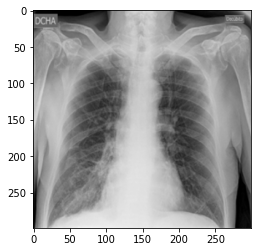

resized_img Dimensions :  (224, 224, 3)


In [34]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/chest_xray_dataset3200/check/Abnormal(Covid)/COVID-2959.png")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)

In [35]:
from keras.activations import softmax, linear

In [36]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''
    
    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()
        
    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)
    
    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)
    
    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear
    
    return model_without_softmax

def backprop_saliency_map(model, img):

    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients (loss, variable)
    func = K.function([variable], [grads, loss])
      
    #use the maximum absolute value among channels per pixel
    w, loss_value = func(img)
    saliency_map = np.max(np.absolute(w[0][0]), axis=2)
    return saliency_map

In [37]:
# Backpropagation saliency map
def backpropagation(model, query_img, visualise=True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, query_img)

    if visualise:
        plt.figure(figsize=(10, 20))
        plt.subplot(121)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(np.squeeze(query_img,0))
        
        plt.subplot(122)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

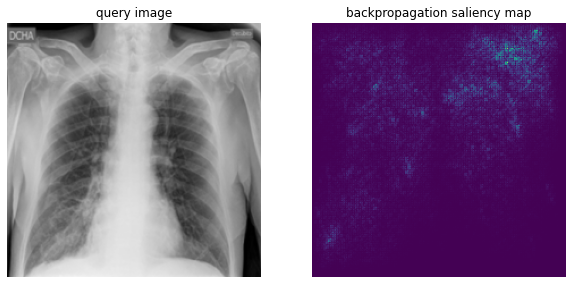

In [38]:
# Backpropagation saliency map
backpropagation(model, np.expand_dims(query_image,0))

In [39]:
# Guided Backpropagation

def build_guided_model():

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [40]:
def guided_backprop_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)

    if visualise:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(132)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

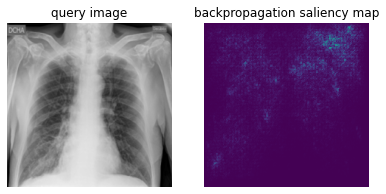

In [41]:
# guided Backpropagation
guided_backprop_saliency_map(model, (query_image), layer_name='conv2d_1')

In [42]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  
    cam = cv2.resize(cam, (224,224))

    return cam

In [46]:
def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='conv2d_1' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(142)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(143)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)
        

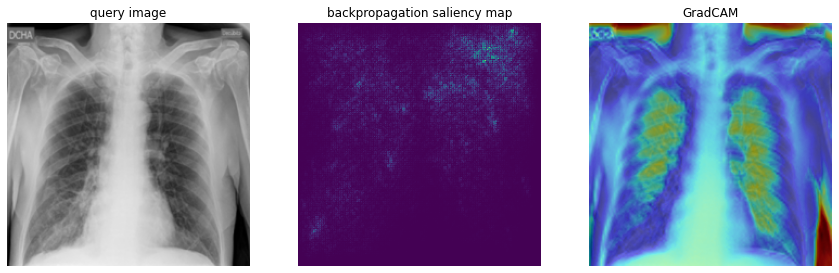

In [47]:
# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'conv2d_1')

In [48]:
# old
def grad_cam_plus(input_model, img, cls, layer_name, H=224,W=224):

    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    # print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = cam / np.max(cam) # scale 0 to 1.0    

    return cam

In [49]:
def GradCamPlusPlus(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img_array])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)
    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)

    cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    height = np.expand_dims(query_image,0).shape[-2]
    weidth = np.expand_dims(query_image,0).shape[-3]
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam) # scale 0 to 1.0  
    cam = cv2.resize(cam, (height, weidth), cv2.INTER_LINEAR)
    
    return cam

In [50]:
def gradcamplus_saliency_map(model, query_input, cls, layer_name  , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcam = gb * gradcam[..., np.newaxis]
    gradcampp = GradCamPlusPlus(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcampp = gb * gradcampp[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(161)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(162)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(163)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(164)
        plt.title('GradCAM ++')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcampp, cmap='jet', alpha=0.5)  


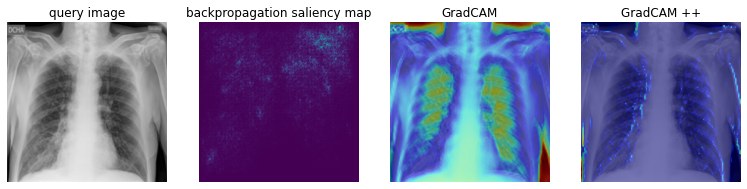

In [51]:
gradcamplus_saliency_map(model, query_image, -1, 'conv2d_1')

Shape of each image : (299, 299, 3)


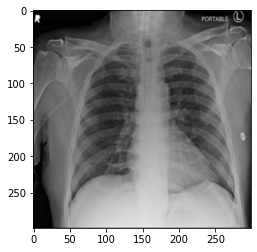

resized_img Dimensions :  (224, 224, 3)


In [52]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/chest_xray_dataset3200/check/Normal/Normal-6433.png")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

In [53]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''
    
    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()
        
    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)
    
    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)
    
    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear
    
    return model_without_softmax

def backprop_saliency_map(model, img):

    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients (loss, variable)
    func = K.function([variable], [grads, loss])
      
    #use the maximum absolute value among channels per pixel
    w, loss_value = func(img)
    saliency_map = np.max(np.absolute(w[0][0]), axis=2)
    return saliency_map

In [1]:
# Backpropagation saliency map
def backpropagation(model, query_img, visualise=True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, query_img)

    if visualise:
        plt.figure(figsize=(10, 20))
        plt.subplot(121)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(np.squeeze(query_img,0))
        
        plt.subplot(122)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

# Backpropagation saliency map
backpropagation(model, np.expand_dims(query_image,0))

NameError: ignored

In [ ]:
# Guided Backpropagation

def build_guided_model():

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [ ]:
def guided_backprop_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)

    if visualise:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(132)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)
# guided Backpropagation
guided_backprop_saliency_map(model, (query_image), layer_name='conv2d_1')

In [ ]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  
    cam = cv2.resize(cam, (224,224))

    return cam

In [ ]:
def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='conv2d_1' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(142)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(143)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'conv2d_120')

In [ ]:
# old
def grad_cam_plus(input_model, img, cls, layer_name, H=224,W=224):

    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    # print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = cam / np.max(cam) # scale 0 to 1.0    

    return cam

In [ ]:
def gradcamplus_saliency_map(model, query_input, cls, layer_name  , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcam = gb * gradcam[..., np.newaxis]
    gradcampp = GradCamPlusPlus(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcampp = gb * gradcampp[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(161)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(162)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(163)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(164)
        plt.title('GradCAM ++')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcampp, cmap='jet', alpha=0.5)  

gradcamplus_saliency_map(model, query_image, -1, 'conv2d_1')

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

In [ ]:
cm = confusion_matrix(y_test_new, pred)

In [ ]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True/Actual label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm,labels)
plt.savefig('DFUEffectiveNetV3CM',dpi=400)

In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

print('Accuracy: %.3f' % accuracy_score(y_test_new, pred), 'Precision: %.3f' % precision_score(y_test_new, pred),' Recall: %.3f' % recall_score(y_test_new, pred), 
      'F1 Score: %.3f' % f1_score(y_test_new, pred), 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred))

In [ ]:
specificity=TN/float(TN+FP)
print(specificity)
print(roc_auc_score(y_test_new, pred))
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_new, pred)

In [ ]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[0].grid()
    
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    axs[1].grid()
    
    
    plt.show()
    
plot_model_history(history)